<a href="https://colab.research.google.com/github/rts1988/Duolingo_spaced_repetition/blob/main/Duolingo_studentfeatures.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook we will look at student based features:
Caveat: we only have data that spans 2 weeks. So we will need to leave the beginning few days out (as they will need to be the basis for the first row)

Also. some of these features will change based on the student's choices. 

1. Average delta (running 3-5 and total)
2. Variance in delta (are they regular?)
2. average words in a day
3. total history correct fraction (basically the mean)
4. number of languages actively learning
5. time active in session - how would we get this?.
6. number of records for this student so far. (session-word pairs)
8. number of records in this day so far?
9. number of new words learned in the last so many days?


All these features are up to the individual timestamps for each record. (cumulative)

First we will get these features for each student. then we will look at how these features help predict performance of two different words. 

There are some issues here because we have some unseen words in the test set. So we will refit when we're ready to get there. 

New plan Jun 25:
Combine with q1 testing dataset. 
Filter to students who have log ins in the last day of the dataset. 

Run models for one word, many students, and see what performance you get (no word features). (delta, history seen, history correct. no session seen included)

Feature engineering:
Get aggregated average from previous days of the dataset. Include feature of number of logins in the last so many days of dataset. 

Run models for one word, many students, and see what performance you get (no word features) - compare with model with only delta, history seen, history correct. 

There's also the one-hot encoding-ish option: get each day's aggregates and make features from those. (14 days * each feature).



In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Your runtime has 54.8 gigabytes of available RAM



In [ ]:
import bz2
import pickle
import _pickle as cPickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

def decompress_pickle(file):
 data = bz2.BZ2File(file, 'rb')
 data = cPickle.load(data)
 return data

def compressed_pickle(title, data):  # do not add extension in filename
 with bz2.BZ2File(title + '.pbz2', 'w') as f: 
  cPickle.dump(data, f)

path_name = '/content/drive/MyDrive/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
datadfq1 = decompress_pickle(path_name+"Unseen_words_training_set.pbz2") 

In [ ]:
datadfq1_test = decompress_pickle(path_name+"Unseen_words_test_set.pbz2") 

In [ ]:
datadfq2 = pd.concat([datadfq1,datadfq1_test],axis=0)

In [ ]:
datadfq2.shape

(9919875, 14)

Quick sanity checks to ensure no duplication after i joined the training and test sets. (There shouldn't be any, but still..)

In [ ]:
datadfq2.duplicated().sum()

0

In [ ]:
del datadfq1, datadfq1_test

Saving for future downloads:

In [142]:
compressed_pickle(path_name+"Unseen_students_training_set",datadfq2)

# Preliminary model with existing features
 (no word features, just delta, history_correct, history_seen, learning language and ui_language)

In [ ]:
#datadfq2 = decompress_pickle("Unseen_students_training_set")

In [ ]:
datadfq2.head()

,p_recall,timestamp,delta,user_id,learning_language,ui_language,lexeme_id,lexeme_string,history_seen,history_correct,session_seen,session_correct,student_word,student_lang
7,1.0,1362082032,444407,u:dDwF,es,en,73eecb492ca758ddab5371cf7b5cca32,bajo/bajo<pr>,3,3,1,1,"(u:dDwF, 73eecb492ca758ddab5371cf7b5cca32)","(u:dDwF, en)"
15,1.0,1362082130,77,u:dDwF,es,en,73eecb492ca758ddab5371cf7b5cca32,bajo/bajo<pr>,5,5,1,1,"(u:dDwF, 73eecb492ca758ddab5371cf7b5cca32)","(u:dDwF, en)"
20,1.0,1362082274,1634777,u:dDwF,es,en,c84476c460737d9fb905dca3d35ec995,niños/niño<n><m><pl>,9,8,2,2,"(u:dDwF, c84476c460737d9fb905dca3d35ec995)","(u:dDwF, en)"
21,1.0,1362082274,1708699,u:dDwF,es,en,1a913f2ded424985b9c02d0436008511,leo/leer<vblex><pri><p1><sg>,7,5,2,2,"(u:dDwF, 1a913f2ded424985b9c02d0436008511)","(u:dDwF, en)"
22,1.0,1362082274,1708699,u:dDwF,es,en,38b770e66595fea718366523b4f7db3f,libro/libro<n><m><sg>,8,8,4,4,"(u:dDwF, 38b770e66595fea718366523b4f7db3f)","(u:dDwF, en)"


Preprocessing and dividing into training and validation sets, so we can compare models. 

In [ ]:
ll_dummies = pd.get_dummies(datadfq2['learning_language'],prefix = 'LL',drop_first=True)

In [ ]:
uil_dummies = pd.get_dummies(datadfq2['ui_language'],prefix = 'UIL',drop_first=True)

In [ ]:
datadfq2 = datadfq2.drop(['learning_language','ui_language'],axis=1)

In [ ]:
datadfq2 = pd.concat([datadfq2,ll_dummies,uil_dummies],axis=1)

In [ ]:
datadfq2.shape

(9919875, 18)

In [ ]:
datadfq2['p_forgot'] = 1 - datadfq2['p_recall']
datadfq2['p_forgot_bin'] = np.where(datadfq2['p_forgot']>0,1,0)

First model: one word, many students - divide into training and validation 90-10. do this for one more word, to see if student based features are providing enough information. 

In [ ]:
datadfq2['lexeme_string'].value_counts().head(5)

a/a<det><ind><sg>                   102534
is/be<vbser><pri><p3><sg>            81360
eats/eat<vblex><pri><p3><sg>         76594
we/prpers<prn><subj><p1><mf><pl>     62387
are/be<vbser><pres>                  57338
Name: lexeme_string, dtype: int64

The top words are very common, so we will only choose one of them. We will go further down for a slightly longer/ more inherently 'difficult' word.

In [ ]:
datadfq2['lexeme_string'].value_counts()[200:220]

aime/aimer<vblex><pri><p1><sg>        11185
taste/taste<n><sg>                    11124
turtle/turtle<n><sg>                  11093
en/en<pr>                             11065
black/black<adj>                      11057
tengo/tener<vblex><pri><p1><sg>       10905
a/a<pr>                               10877
non/non<adv>                          10827
diario/diario<n><m><sg>               10809
cebolla/cebolla<n><f><sg>             10792
spider/spider<n><sg>                  10747
comida/comida<n><f><sg>               10723
newspapers/newspaper<n><pl>           10689
who/who<prn><itg><m><sp>              10680
cocino/cocinar<vblex><pri><p1><sg>    10580
elephants/elephant<n><pl>             10579
animal/animal<n><m><sg>               10575
caballo/caballo<n><m><sg>             10544
horses/horse<n><pl>                   10525
elefantes/elefante<n><m><pl>          10473
Name: lexeme_string, dtype: int64

We can choose newspaper: 
```newspaper/newspaper<n><sg>``` and 
```
turtle/turtle<n><sg>
```

Number of students who learned 'newspaper':

In [ ]:
len(datadfq2.loc[datadfq2['lexeme_string']=="newspaper/newspaper<n><sg>",'user_id'].unique())

11145

11145 unique students learned the word newspaper. We will use this as a first model. We don't want the same students in the training and validation set. So we will partition the students first, then use the separate student lists to make the traiing and validation set. 

In [ ]:
newspaper_students = datadfq2.loc[datadfq2['lexeme_string']=="newspaper/newspaper<n><sg>",'user_id'].unique()

In [ ]:
newspaper_training_students = np.random.choice(newspaper_students,int(0.9*len(newspaper_students)),replace=False)

In [ ]:
newspaper_valid_students = set(newspaper_students).difference(set(newspaper_training_students))

In [ ]:
len(newspaper_training_students), len(newspaper_valid_students)

(10030, 1115)

Now that the students are divided, we just need to divvy up the dataframe datadfq2 to make the training and test sets. 

In [ ]:
newspapertrain = datadfq2.loc[(datadfq2['lexeme_string']=="newspaper/newspaper<n><sg>") &\
                              datadfq2['user_id'].isin(newspaper_training_students),:]
newspapervalid = datadfq2.loc[(datadfq2['lexeme_string']=="newspaper/newspaper<n><sg>") &\
                              datadfq2['user_id'].isin(newspaper_valid_students),:]

In [ ]:
newspapertrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22294 entries, 289 to 12854146
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   p_recall         22294 non-null  float64
 1   timestamp        22294 non-null  int64  
 2   delta            22294 non-null  int64  
 3   user_id          22294 non-null  object 
 4   lexeme_id        22294 non-null  object 
 5   lexeme_string    22294 non-null  object 
 6   history_seen     22294 non-null  int64  
 7   history_correct  22294 non-null  int64  
 8   session_seen     22294 non-null  int64  
 9   session_correct  22294 non-null  int64  
 10  student_word     22294 non-null  object 
 11  student_lang     22294 non-null  object 
 12  LL_es            22294 non-null  uint8  
 13  LL_fr            22294 non-null  uint8  
 14  LL_it            22294 non-null  uint8  
 15  LL_pt            22294 non-null  uint8  
 16  UIL_es           22294 non-null  uint8  
 17  UIL_pt 

In [ ]:
newspapertrain.columns

Index(['p_recall', 'timestamp', 'delta', 'user_id', 'lexeme_id',
       'lexeme_string', 'history_seen', 'history_correct', 'session_seen',
       'session_correct', 'student_word', 'student_lang', 'LL_es', 'LL_fr',
       'LL_it', 'LL_pt', 'UIL_es', 'UIL_pt', 'p_forgot', 'p_forgot_bin'],
      dtype='object')

Getting X,y for train and validation:

In [ ]:
Xnewspapertrain = newspapertrain[['delta','history_correct','history_seen']+\
                                 [col for col in newspapertrain.columns if col.startswith('LL_')]+\
                                 [col for col in newspapertrain.columns if col.startswith('UIL_')]]
ynewspapertrain = newspapertrain['p_forgot_bin']

In [ ]:
Xnewspapervalid = newspapervalid[['delta','history_correct','history_seen']+\
                                 [col for col in newspapertrain.columns if col.startswith('LL_')]+\
                                 [col for col in newspapertrain.columns if col.startswith('UIL_')]]
ynewspapervalid = newspapervalid['p_forgot_bin']

In [ ]:
Xnewspapertrain.shape, ynewspapertrain.shape, Xnewspapervalid.shape, ynewspapervalid.shape

((22294, 9), (22294,), (2378, 9), (2378,))

Checking for class imbalance:

In [ ]:
ynewspapertrain.sum()/ynewspapertrain.shape[0], ynewspapervalid.sum()/ynewspapervalid.shape[0]

(0.21875841033461918, 0.21783010933557612)

By serendipity, the class imbalance is about the same in both training and testing even though we didn't explicitly stratify. (Both training and testing have ~21.7% records with target variable = 1)

Scaling data:

In [ ]:
from sklearn.preprocessing import MinMaxScaler
mmscaler = MinMaxScaler()
Xnewspapertrain_mm = mmscaler.fit(Xnewspapertrain)

Xnewspapertrain_mm = mmscaler.transform(Xnewspapertrain)
Xnewspapervalid_mm = mmscaler.transform(Xnewspapervalid)



In [ ]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(class_weight = 'balanced',C=1)
logreg.fit(Xnewspapertrain_mm,ynewspapertrain)

LogisticRegression(C=1, class_weight='balanced')

In [ ]:
ynewspapervalid_predprobs = logreg.predict_proba(Xnewspapervalid_mm)[:,1]
ynewspapertrain_predprobs = logreg.predict_proba(Xnewspapertrain_mm)[:,1]

In [ ]:
from sklearn.metrics import accuracy_score, PrecisionRecallDisplay

print(accuracy_score(ynewspapertrain, np.where(ynewspapertrain_predprobs>=0.5,1,0)))
print(accuracy_score(ynewspapervalid, np.where(ynewspapervalid_predprobs>=0.5,1,0)))

0.3953081546604468
0.3599663582842725


Only 36% accuracy. seems worse than the baseline of guessing all zeros. 

Text(0.5, 1.0, 'Logistic regression Precision Recall Curve')

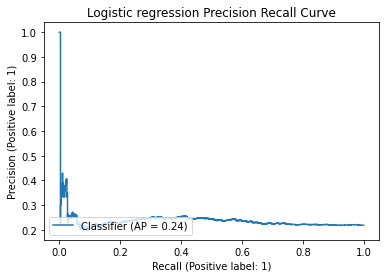

In [ ]:
PrecisionRecallDisplay.from_predictions(ynewspapervalid,ynewspapervalid_predprobs)
plt.title("Logistic regression Precision Recall Curve")

Poor accuracy and precision with logistic regression. 
Trying XGBoost:

In [ ]:
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler


XGB_model = XGBClassifier(num_feature = 5,subsample = 0.5)
XGB_model.fit(Xnewspapertrain_mm, ynewspapertrain)
print(f"XG Boost train set score: {XGB_model.score(Xnewspapertrain_mm, ynewspapertrain)}")
print(f"XG Boost test set score: {XGB_model.score(Xnewspapervalid_mm, ynewspapervalid)}")

XG Boost train set score: 0.7813761550192877
XG Boost test set score: 0.7821698906644239


This gives a better accuracy, but essentially around the baseline of all zeros. Potting Precision Recall Curve for validation set:

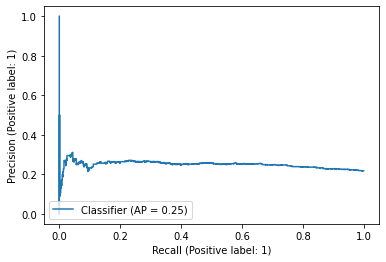

In [ ]:
ynewspapervalid_preds_probs_xgb = XGB_model.predict_proba(Xnewspapervalid_mm)[:,1]
PrecisionRecallDisplay.from_predictions(ynewspapervalid,ynewspapervalid_preds_probs_xgb)

In [ ]:
np.where(ynewspapervalid_preds_probs_xgb>=0.5,1,0).sum()

0

There are no ones. We have basically got the all zero baseline. 

This set of features does not suffice to predict student performance. 

Previously we tried a many-word one student model and were able to achieve 0.78 precision with 0.87 recall. This points to student based features being more important than word based features to predicting forgetting a word. 

Plan: 
1. Parse out which students have log ins on the last day of the dataset.
2. Get aggregated student feature data for them alone.
3. split those students into training and testing
4. add those aggregated features to the last date dataset, and split dataset into training and testing.  


Converting timestamp to datetime objects [link](https://stackoverflow.com/questions/9744775/how-to-convert-integer-timestamp-into-a-datetime)

In [ ]:
from datetime import datetime
datadfq2['Datetime'] = datadfq2['timestamp'].apply(lambda x: datetime.fromtimestamp(x))

In [ ]:
datadfq2['Datetime'].head()

7    2013-02-28 20:07:12
15   2013-02-28 20:08:50
20   2013-02-28 20:11:14
21   2013-02-28 20:11:14
22   2013-02-28 20:11:14
Name: Datetime, dtype: datetime64[ns]

In [ ]:
datadfq2['Datetime'].describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                 9919875
unique                 477749
top       2013-03-01 20:07:14
freq                      192
first     2013-02-28 20:07:12
last      2013-03-12 16:14:54
Name: Datetime, dtype: object

Last day is Mar 12, 2013. Let us count the students who logged in that day. 

In [ ]:
datadfq2['Date'] = datadfq2['Datetime'].dt.date

In [ ]:
datadfq2['Date'].head()

7     2013-02-28
15    2013-02-28
20    2013-02-28
21    2013-02-28
22    2013-02-28
Name: Date, dtype: object

In [ ]:
lastdaylogs = datadfq2.loc[datadfq2['Date']==datetime.strptime('12032013', "%d%m%Y").date(),:]

In [ ]:
lastdaylogs.shape

(492966, 22)

In [ ]:
lastdayusers = lastdaylogs['user_id'].unique()

In [ ]:
len(lastdayusers)

11411

Only 11411 students logged in on the last day, with 492966 total records. This is a substantially smaller dataset. I just hope at least some students in the q2 testing set have logged in on the last day if we decide to go with these features. 



Let us split the last day students into training and testing, since we do not want to see the same students in the validation set.  

In [ ]:
np.random.seed(123)
lduserstrain = np.random.choice(lastdayusers,int(0.9*len(lastdayusers)),replace=False) # sample from list without replacement
ldusersvalid = set(lastdayusers).difference(lduserstrain)

In [ ]:
len(lduserstrain),len(ldusersvalid)

(10269, 1142)

In [222]:
datadfq2.shape

(9919875, 22)

In [225]:
datadfq2['Date'].values[0]

datetime.date(2013, 2, 28)

In [229]:
datetime.strptime('12032013',"%d%m%Y").date()

datetime.date(2013, 3, 12)

In [230]:
datadfq2dates = datadfq2.loc[datadfq2['Date']!=datetime.strptime('12032013', "%d%m%Y").date()]
datadfq2dates.shape

(9426909, 22)

In [231]:
userdates = datadfq2.loc[(datadfq2['Date']!=datetime.strptime('12032013', "%d%m%Y").date()) & \
                         (datadfq2['user_id'].isin(lastdayusers))].groupby(['user_id','Date']).agg(numseen_day = ('session_seen','sum'), avgp_recall_day = ('p_recall','mean'),numwordspracticed_day = ('lexeme_id',lambda x: len(x.unique())), numcorrect_day = ('session_correct','sum'), numquizzes_day = ('session_seen','count'), avgdelta_day = ('delta','mean'), avgactivesessions = ('timestamp',lambda x: len(x.unique())), 
                                     mintimestamp = ('timestamp','min'),maxtimestamp = ('timestamp','max'))

In [232]:
userdates['duration'] = userdates['maxtimestamp'] - userdates['mintimestamp']

In [233]:
studentfeatures1 = userdates.transpose().stack().fillna(0)

In [234]:
studentfeatures2 = studentfeatures1.transpose()

In [247]:
studentfeatures2 = studentfeatures2.reset_index()

In [248]:
studentfeatures2.head()

user_id numseen_day                                              \
Date          2013-02-28 2013-03-01 2013-03-02 2013-03-03 2013-03-04   
0      u:-Md         0.0        0.0      150.0       58.0       68.0   
1      u:-Ou         0.0        0.0        0.0        0.0       50.0   
2      u:-TS         0.0        0.0        0.0        0.0       29.0   
3       u:-b         0.0       63.0      563.0     1026.0      138.0   
4      u:-f2         0.0        0.0        0.0        0.0        0.0   

                                                  ...   duration             \
Date 2013-03-05 2013-03-06 2013-03-07 2013-03-08  ... 2013-03-02 2013-03-03   
0          43.0        0.0        0.0       92.0  ...     2953.0     1394.0   
1          29.0        0.0        0.0        0.0  ...        0.0        0.0   
2           0.0       16.0        0.0       28.0  ...        0.0        0.0   
3         204.0      513.0        0.0      330.0  ...    78035.0    85701.0   
4           0.0        0.0       54.0      103.0  ...        0.0        0.0   

                                                                        \
Date 2013-03-04 2013-03-05 2013-03-06 2013-03-07 2013-03-08 2013-03-09   
0         656.0      190.0        0.0        0.0    49198.0        0.0   
1           0.0        0.0        0.0        0.0        0.0        0.0   
2         378.0        0.0        0.0        0.0      321.0        0.0   
3         241.0     1553.0    75182.0        0.0     6550.0    85506.0   
4           0.0        0.0        0.0      284.0     1073.0        0.0   

                            
Date 2013-03-10 2013-03-11  
0       60209.0     4091.0  
1           0.0        0.0  
2         664.0        0.0  
3       83424.0    85559.0  
4           0.0     2913.0  

[5 rows x 121 columns]

In [236]:
newcolumns = [str(x[0])+'_'+str(x[1]) for x in studentfeatures2.columns]


Now we will join the studentfeatures to the Mar 12 dataset. Then we will join the word features, then split, then convert to sparse arrays.  

In [237]:
compressed_pickle(path_name+"studentfeatures2",studentfeatures2)

Getting Mar 12 dataset

In [240]:
lastdayq2 = datadfq2.loc[(datadfq2['Date']==datetime.strptime('12032013', "%d%m%Y").date()),:]

In [241]:
lastdayq2.shape

(492966, 22)

In [249]:
lastdayq2wstfeatures = pd.merge(left = lastdayq2,right = studentfeatures2,left_on='user_id',right_on = 'user_id',how="left")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left,2 on the right)
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [250]:
lastdayq2wstfeatures.shape

(492966, 142)

Now we get q1lexeme features and attach them, then we get rid of unnecessary columns. then we split by students into train and test. 

In [251]:
lastdayq2

,p_recall,timestamp,delta,user_id,lexeme_id,lexeme_string,history_seen,history_correct,session_seen,session_correct,...,"(duration, 2013-03-02)","(duration, 2013-03-03)","(duration, 2013-03-04)","(duration, 2013-03-05)","(duration, 2013-03-06)","(duration, 2013-03-07)","(duration, 2013-03-08)","(duration, 2013-03-09)","(duration, 2013-03-10)","(duration, 2013-03-11)"
0,1.0,1363046401,1123854,u:inBD,4452601308c9aeb4f25f01fb6710ed16,salsa/salsa<n><f><sg>,2,2,1,1,...,0.0,0.0,983.0,0.0,0.0,0.0,0.0,0.0,0.0,3605.0
1,1.0,1363046401,1125308,u:inBD,bdb10c2d4f793986f32986d746051a59,fresas/fresa<n><f><pl>,3,3,1,1,...,0.0,0.0,983.0,0.0,0.0,0.0,0.0,0.0,0.0,3605.0
2,0.0,1363046401,1123854,u:inBD,890f121972386ce1dbb811304e774f3f,comida/comida<n><f><sg>,2,2,1,0,...,0.0,0.0,983.0,0.0,0.0,0.0,0.0,0.0,0.0,3605.0
3,1.0,1363046401,73543,u:inBD,a52bc2771bde31d4d5e80bd29f350714,manzana/manzana<n><f><sg>,6,6,1,1,...,0.0,0.0,983.0,0.0,0.0,0.0,0.0,0.0,0.0,3605.0
4,1.0,1363046401,1125985,u:inBD,08bb4120ecb09c3cc4a544af3f119f6d,pasta/pasta<n><f><sg>,3,3,1,1,...,0.0,0.0,983.0,0.0,0.0,0.0,0.0,0.0,0.0,3605.0


numseen_day: how many individual questions were done in the day
avgp_recall_day: the average number of questions answered correctly (should word out to be derivable)
numwordspraciced_day: how many individual words were practiced in that day.
numcorrect_day: how many questions were asnwered correctly in that day
numsessions_day: how many individual sessions


As EDA, we can try to cluster the students based on their behavior. or look at their performance on certain words, and what separates students who forget vs students who don't for around the same delta and history seen. 

For now, we can add the previous learning day's features to each record of the next learning day. if there is none, maybe we can impute the total average although that would be data leakage. maybe do a time based split?

1. get all users up to first 10 days or so, then see if you can predict performance on the next 4 days?

Clustering students:

We may have to look at features for only a subset of the data where we have enough - but this would disproportionately get rid of 'irregular' students. so we shouldn't.

numseen_day: number of questions seen that day
avgp_recall_day - average p_recall per word-session (not the same as numcorrect_day/numseen_day)
numwordspracticed_day: number of unique words practiced that day
numcorrect_day : number of questions answered correctly that day
numquizzes_day: number of quizzes taken per word (number of records that day)
avgdelta_day: the average interval since the last quiz - this is an aggregate measure of the choice made by the student - if avgdelta is low, then they mostly reviewed recent words, if avgdelta is high, then they mostly reviewed words that were learned a while ago. 
avgactivesessions - might be an artefact of how timestamps are recorded, but essentially the number of unique timestamps - if this number is high, student was active during 


In [ ]:
310/446

0.695067264573991

In [ ]:
lexemeids = datadfq1['lexeme_id']
lexemeids = pd.DataFrame(lexemeids)

Getting q1lexemes, getting indices of lexeme id. then joining just those. 

In [ ]:
q1lexemes = decompress_pickle(path_name+"q1_lexeme_features.pbz2")

In [ ]:
q1lexemes.shape

(12160, 2292)

In [ ]:
q1lexemeids=pd.DataFrame(q1lexemes['lexeme_id'])

In [ ]:
q1lexemeids = q1lexemeids.reset_index()
q1lexemeids.head()

,index,lexeme_id
0,0,73eecb492ca758ddab5371cf7b5cca32
1,1,c84476c460737d9fb905dca3d35ec995
2,2,1a913f2ded424985b9c02d0436008511
3,3,38b770e66595fea718366523b4f7db3f
4,4,4bdb859f599fa07dd5eecdab0acc2d34


In [ ]:
lexemeids.shape, q1lexemeids.shape

((7313354, 1), (12160, 2))

Now we will map the main dataframe indices to the lexeme features indices.

In [ ]:
lexeme_map = pd.merge(left=lexemeids,right=q1lexemeids, how='left',left_on = 'lexeme_id',right_on = 'lexeme_id')

In [ ]:
lexeme_map.head()

,lexeme_id,index
0,73eecb492ca758ddab5371cf7b5cca32,0
1,73eecb492ca758ddab5371cf7b5cca32,0
2,c84476c460737d9fb905dca3d35ec995,1
3,1a913f2ded424985b9c02d0436008511,2
4,38b770e66595fea718366523b4f7db3f,3


index column here contains the row of the q1lexemes dataframe that needs to be concatenated to the main dataframe.


Row-wise concatenation using getrow() was taking too long (see below commented cells), so we will instead convert q1lexemes to a coo matrix - > get a dictionary of keys, and use that to construct the bigger matrix. 

There are still some non-numeric columns that need to be converted to binaries or deleted. we will do this first. 

In [ ]:
compressed_pickle(path_name+"lexeme_map",lexeme_map)

In [ ]:
q1lexemes.select_dtypes('object').head()

,lexeme_id,learning_language,lexeme_string,surface_form,lemma_form,pos,modstrings
0,73eecb492ca758ddab5371cf7b5cca32,es,bajo/bajo<pr>,bajo,bajo,pr,[]
1,c84476c460737d9fb905dca3d35ec995,es,niños/niño<n><m><pl>,niños,niño,n,"[m, pl]"
2,1a913f2ded424985b9c02d0436008511,es,leo/leer<vblex><pri><p1><sg>,leo,leer,vblex,"[pri, p1, sg]"
3,38b770e66595fea718366523b4f7db3f,es,libro/libro<n><m><sg>,libro,libro,n,"[m, sg]"
4,4bdb859f599fa07dd5eecdab0acc2d34,es,a/a<pr>,a,a,pr,[]


Converting pos to binaries. 

In [ ]:
pos_dummies = pd.get_dummies(q1lexemes['pos'],prefix='pos')
q1lexemes = pd.concat([q1lexemes,pos_dummies],axis=1)

In [ ]:
q1lexemes['pos']

,pos,pos,pos
0,pr,0.0,0.0
1,n,0.0,0.0
2,vblex,0.0,0.0
3,n,0.0,0.0
4,pr,0.0,0.0
...,...,...,...
12155,vblex,0.0,0.0
12156,n,0.0,0.0
12157,n,0.0,0.0
12158,vblex,0.0,0.0


In [ ]:
q1lexemes['pos1'] = pd.Series([q1lexemes['pos'].loc[i][1] for i in range(q1lexemes['pos'].shape[0])])

In [ ]:
q1lexemes = q1lexemes.drop(['lexeme_id','lexeme_string','learning_language','surface_form','lemma_form','pos','modstrings'],axis=1)

In [ ]:
q1lexemes.select_dtypes('object')

""
0
1
2
3
4
...
12155
12156
12157
12158


No strings left in the q1lexemes dataframe. We can now convert to coo matrix. 

In [ ]:
q1lexemes.size/1000000

27.87072

In [ ]:
q1lexemecoo = coo_matrix(np.array(q1lexemes))

In [ ]:
q1lexemecoo.size/1000000

0.151624

Failed attempt at row-wise concatenation:

In [ ]:
#Very sparse matrix. now we will index a row.
#q1lexemecoo.getrow(0)

#Will go row_wise in lexeme_map, and get the row from the indices, and concatenate. 
# from scipy.sparse import hstack

# lexemes_coo  = q1lexemecoo.getrow(lexeme_map.iloc[0,1])

# for i,row in lexeme_map.tail(-1).iterrows():
#   if i%1000 == 0:
#     print(i,' rows done',end='\r')
#   lexemes_coo = hstack((lexemes_coo,q1lexemecoo.getrow(row['index'])))
# lexemes_coo.shape

<1x2291 sparse matrix of type '<class 'numpy.float64'>'
	with 9 stored elements in Compressed Sparse Row format>

Converting to dictionary of keys

In [ ]:
q1lexemecoo_dok = q1lexemecoo.todok(copy=True)

Let's look at the first 10 values of the ductionary. 

In [ ]:
list(q1lexemecoo_dok.items())[0:10]

[((0, 0), 7.0),
 ((0, 1), 4.0),
 ((0, 87), 1.0),
 ((0, 141), 0.35263237459267294),
 ((0, 144), 0.4122115155582215),
 ((0, 275), 0.28469397919105377),
 ((0, 276), 0.3929244102341387),
 ((0, 1027), 0.32488787493717813),
 ((0, 2280), 1.0),
 ((1, 0), 20.0)]

We can return the first row as: 

In [ ]:
list(q1lexemecoo_dok[0].items())

[((0, 0), 7.0),
 ((0, 1), 4.0),
 ((0, 87), 1.0),
 ((0, 141), 0.35263237459267294),
 ((0, 144), 0.4122115155582215),
 ((0, 275), 0.28469397919105377),
 ((0, 276), 0.3929244102341387),
 ((0, 1027), 0.32488787493717813),
 ((0, 2280), 1.0)]

We can create a new coo matrix from a dictionary of keys we defined.

In [ ]:
keyvals = [(key,val) for (key,val) in q1lexemecoo_dok[0].items()]
vals = [val for (key,val) in keyvals]
rows = [key[0] for (key,val) in keyvals]
cols = [key[1] for (key,val) in keyvals]

coo = coo_matrix((vals, (rows, cols)))

spmatrix = coo.toarray()
spmatrix

array([[7., 4., 0., ..., 0., 0., 1.]])

add a row to a dictionary, with the row number updated with the main dataframe row. 

In [ ]:
vals = []
rows = []
cols = []

count = 0
for i in lexeme_map['index']:
  if count%1000 == 0:
    print(count," rows done")
  keyvals = [(key,val) for (key,val) in q1lexemecoo_dok[i].items()]
  vals = vals + [val for (key,val) in keyvals]
  cols = cols + [key[1] for (key,val) in keyvals]
  rows = rows + [i]*len(keyvals)
  count +=1 

0  rows done
1000  rows done
2000  rows done
3000  rows done
4000  rows done
5000  rows done
6000  rows done
7000  rows done
8000  rows done
9000  rows done
10000  rows done
11000  rows done
12000  rows done
13000  rows done
14000  rows done
15000  rows done
16000  rows done
17000  rows done
18000  rows done
19000  rows done
20000  rows done
21000  rows done
22000  rows done
23000  rows done
24000  rows done
25000  rows done
26000  rows done
27000  rows done
28000  rows done
29000  rows done
30000  rows done
31000  rows done
32000  rows done
33000  rows done
34000  rows done
35000  rows done
36000  rows done
37000  rows done
38000  rows done
39000  rows done
40000  rows done


KeyboardInterrupt: ignored

We can construct the dictionary so that we use the 'index' column in the main dataframe change the row numbers to match the row of the main dataframe. 

The pseudocode is below:

initialize a dictionary that will be the sparse matrix:
word_features = dict()

For each row in the lexemes dataframe:<br>
  >indexnumbers = Get the rows of the main dataframe with that word from the 'index' column<br>
  >for each number in indexnumbers:<br>
  >>copy the row of q1lexemes, and change the row number to be same as main dataframe row. 
    
Convert the dictionary to a sparse matrix. 

Another alternative is to get counts of p_forgot_bin and number of sessions for each word, and model just the word features. this is another possibility for reducing size: feature selection. 

Pseudocode:
transform delta for finer granularity, and get bins, 
groupby the lexeme_id, and bins and get p_forgot counts for 1 and 0. also num students for each delta? and total? should we also get bin by history correct/ history and group by both delta and fraction history correct? 

table:
lexeme id, lexeme id features, p_forgot_1_counts list, p_forgot_0_counts list, delta_bins_list, history_frac_list 